# **Implementing First-order Backpropagation of MLP Using *numpy***
*A PC3270 Project by Zhai Jun (A0225682B)*

----
## Abstract
This project aims to implement from the beginning a fully-functioning Multilayer Perceptrons (MLP), mainly the **backpropagation algorithm** (backprop), with `numpy`. I will largely refer to Murphy Section 13.3 and use the Stochastic Gradient Descent (SGD) algorithm for my backprop. This implementation will be compared to and evaluated against one built with `tensorflow.keras` for accuracy of classification of the test data. I will use `tf.keras.datasets.mnist` (MNIST dataset of hand written digits) to generate the train and test data.

## 1. Motivation
<img src="Animation.gif" width="750" align="center">
<b>Figure 1. Screenshot of a MLP Classifier in Work </b>
(<i>Source</i>: <a href="http://playground.tensorflow.org/"> <i>Tensorflow Playground</i></a>)<br><br>
MLP is the foundation of all modern feedforward Artificial Neural Network (ANN) architectures. It carries great importance for the development of subsequent Neural Networks such as Convolutional Neural Networks (CNNs).<br>

In the eleventh lecture we were introduced to the forward- and back- propagation algorithms. However, only the forward propagation was present in our laboratory. Our missions involved only rewritting the forward propagation and retrieving activations from a MLP. No practical emphasis was placed on how the algorithm learns the weights and biases -- how the model trains to classify labels. This is the job of the backprop algorithm. Admittedly, the backprop is more complicated and mathematically intense. To have a complete understanding of how MLP learns the weights and biases, an understanding of backprop is essential. Therefore, I think it is vastly beneficial for me to implement this from the very begining, to have a firm understanding of neural networks for my future studies.

## 2. Dataset

The data set that is chosen for learning is the Modified National Institute of Standards and Technology (MNIST) database of handwritten digits. It has a training set of 60,000 examples, and a test set of 10,000 examples. The digits are greyscale, have been size-normalized and centered in a fixed-size image. Generally, it is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. 

It is decided not to use simplier datasets such as `blinkers.py` from PC3270 library since such a classification can be done with a simplest implementation of the Perceptron algorithm and do not require MLP. As the primary example of Murphy, MNIST is the classic dataset for testing out MLPs.

However, it is worth noting that image data such as `tf.keras.datasets.mnist` and `tf.keras.datasets.cifar10` do not work best with MLP. This is because MLP does not exhibit translation invariance like CNNs, which takes in data as matrices instead of having them flattened into arrays. It is expected that if the images are translated or rotated, the trained MLP's model accuracy will be low, same goes to one trained with tensorflow implementation of MLP with a better optimizer than SGD (such as Adam). This is an intrinsic limitation of MLP's archtecture. Under those circumstances, `tensorflow.keras` does not produce high enough accuracy benchmark for judging whether my implementation of MLP is a good one. We will see more of that later in the discussion section.

My data is generated as below.

In [91]:
from keras.datasets import mnist

We extract MNIST from `keras.datasets.mnist`.

In [92]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print('X_train: ', str(X_train.shape))
print('Y_train: ', str(Y_train.shape))
print('X_test:  ', str(X_test.shape))
print('Y_test:  ', str(Y_test.shape))

X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:   (10000, 28, 28)
Y_test:   (10000,)


In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Sample images of the MNIST dataset are plotted below.

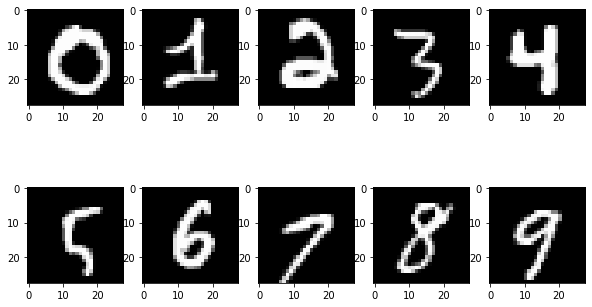

In [94]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,6))
for i in range(10):
    img = X_train[Y_train == i][5]
    ax[int(i/5)][i%5].imshow(img, cmap='gray')

**Figure 2a. MNIST Handwritten Digits**

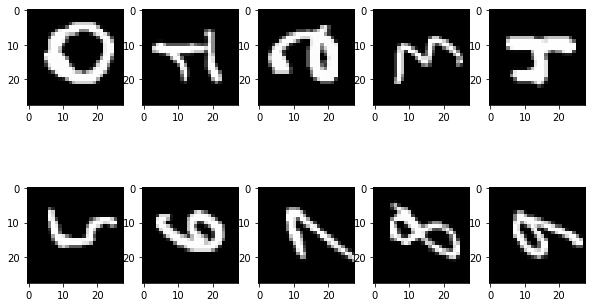

In [95]:
#I also rotated each digit counter-clockwise by 90 degrees, this will only be used in the discussion section
X_train_T, X_test_T = np.asarray([X.T for X in X_train]), np.asarray([X.T for X in X_test])
X_train_T, X_train_T = X_train_T[:,::-1], X_train_T[:,::-1]
fig2, ax2 = plt.subplots(nrows=2, ncols=5, figsize=(10,6))
for i in range(10):
    img = X_train_T[Y_train == i][5]
    ax2[int(i/5)][i%5].imshow(img, cmap='gray')

**Figure 2b. MNIST Handwritten Digits** (Rotated Counter-clockwise for $90^\circ$)

This data must be preprocessed to fit a MLP model.

Flattening and Normalizing:

In [96]:
X_train, X_test = np.asarray([X.flatten() for X in X_train]), np.asarray([X.flatten() for X in X_test])
X_train, X_test = X_train / 255, X_test / 255
print('X_train: ', str(X_train.shape))
print('X_test: ', str(X_test.shape))

X_train:  (60000, 784)
X_test:  (10000, 784)


Using sklearn's One Hot Encoder to turn the labels into one hot numeric arrays:

In [97]:
OneHot = OneHotEncoder(sparse=False, categories='auto')
Y_train, Y_test = OneHot.fit_transform(Y_train.reshape(len(Y_train), -1)), OneHot.transform(Y_test.reshape(len(Y_test), -1))

----
## **3. Model and Training**
### 3.1 Theory
<img src="MLP.gif" width="600" align="center">
<b>Figure 3. A Schematic of Forward- and back- propagation with their parameters</b> (<i>Source</i>: <a href="https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795"> <i>Piotr Skalski</i></a>)

Let me take the example of linear regression, which we may be more familiar with. We have all encountered linear regression before, when it involves finding the best-fit line through a set of two dimensional data points-$(x,y)$. This is done by choosing the gradient and offset of the line that minimizes the Mean-Squared Error (MSE). MSE here is called the objective function that we are trying to minimize, while gradient and offset of the line are called the model parameters. When you give such a question to a machine, there are a few methods you can ask it to follow: 
>* **First**, you can tell it to do a grid search, that is, setting a range and step size, and feed the machine all the $(x,y)$ in that grid that you specified, let it calculates the MSE of all the points and output the point that has the least MSE. 
>* **Second**, you can tell the machine to search methodically instead of going through every point on the grid. The classic method here is the *Gradient Descent*, that is for the machine to follow a path along the least gradient of objective function (path of the greatest descent). 
>* **Third**, if you can obtain a closed formula for each of the module parameters (in this case you can) that will give the least MSE when inputting all the points $(x,y)$, then you can directly calculate the best-fit line. The parameters you calculated here can be as precise as you want and this is of course more accurate than the previous methods. However, this is far less general a method.

Generally, *Stochastic Gradient Descent* is formulated as:

$\begin{equation}\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t - \eta_t \nabla \mathcal{L}(\boldsymbol{\theta}_t,z_t) = \boldsymbol{\theta}_t - \eta_t \boldsymbol{g}_t\end{equation}\tag{Murphy 8.54}$

where $\boldsymbol{\theta}$ are the model parameters, $\eta$ is the step size (or learning rate), $\mathcal{L}(\boldsymbol{\theta},z)$ is the objective function and $\boldsymbol{g}$ is the gradient.

In simple classification problems (e.g. classifying a distribution of point on a grid), we use the perceptron algorithm. The goal is in short to learn the parameters (weight and biases) of one or many linear boundary function. When given a point, it tells whether it belongs to a class from the sign of the output. However, in more complicated scenarios, such as non-linear logistic regression or the XOR problem, a single layer of Perceptrons would not suffice.<br>
<img src="perceptron.png" width="600" align="center"><br>
**Figure 4. The Perceptron Function** (<i>Source</i>: <a href="https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53"> <i>SAGAR SHARMA</i></a>)

From the diagrams below. it is obvious that we can draw a linear boundary to separate the green and red points in the first distribution, but it is impossible in the second distribution. We need a higher-order boundary, say, a three dimensional surface, in order to classify the points.<br>
<img src="xor.webp" width="700" align="center"><br>
**Figure 5. The OR and XOR Problems** (<i>Source</i>: <a href="https://dev.to/jbahire/demystifying-the-xor-problem-1blk"> <i>Jayesh Bapu Ahire</i></a>)

In the other example, to fit a polynomial boundary, we tranditionally use a polynomial transformation of the data. That is, instead of fitting $f(\boldsymbol{x},\boldsymbol{\theta})=\boldsymbol{W}\boldsymbol{x} + \boldsymbol{b}$, where $\boldsymbol{\theta}=(\boldsymbol{W}, \boldsymbol{b})$, we use $f(\boldsymbol{x},\boldsymbol{\theta})=\boldsymbol{W}\phi(\boldsymbol{x}) + \boldsymbol{b}$, where $\phi(x) = \{1, x, x^2, ...\}$. A natural extension to such a method is that we can transform our data $\boldsymbol{x}$ for any number of times, say $L$ times, this gives rise to:

$f(\boldsymbol{x},\boldsymbol{\theta})=f_L(f_{L-1}(...(f_1(x))...)) \tag{Murphy 13.3}$

where $f_\ell(\boldsymbol{x})=f_\ell(\boldsymbol{x},\boldsymbol{\theta})$ is the function at layer $\ell$. This is the key idea behind Deep Neural Networks (DNNs).

### 3.1.1 MLP Architecture

Figures 1 & 3 shows structure and schematic of sample MLPs. A MLP has at least three layers of node, including the input layer, at least one hidden layer and the output layer (see Figure 1). Except for the input nodes, each node is a neuron that uses a nonlinear *activation function*. This is necessary to fit nonlinear functions, since it can be shown by linear algebra (composition of linear transformations is itself a linear transformation) that any number of layers of nodes with linear activation can be reduced to a two-layer input-output module. The passing of input design matrix into a MLP can be written as a set of recurrence realtions between layer outputs and activations, this is known as the forward pass of the MLP:

$$\begin{cases}Z_L = W_L A_{L-1} + b_L\\
 A_L = \sigma(Z_L)\end{cases}$$

where $Z_L$ is the $L^{th}$ layer output (before activation), $\sigma$ is the activation function, $A_L$ is the activation at $L^{th}$ layer, and $W_L$, $b_L$ are the model parameters at $L^{th}$ layer.

### 3.1.2 Activation function and loss function

The most widely used (nonlinear) activation function in the hidden layers is the Rectified Linear Unit (ReLU). It is defined as:

$ReLU(a) =\max(0,a) = a \mathbb{I} (a>0)\tag{Murphy 13.12}$

where $(a>0)$ gives 1 if true, otherwise 0. The main advantage of using ReLU over the other activation functions (say tanh or sigmoid) is that it does not activate all the neurons at the same time (the neurons will only be deactivated if the output of the linear transformation is less than 0). Since only a certain number of neurons are activated, the ReLU function is far more computationally efficient when compared to the sigmoid and tanh function. 

The objective (loss) function for a multiclass classification problem is the cross entropy, defined as:

$\mathbb{H}(p,q)\triangleq - \sum_{k=1}^{K}p_k \log q_k\tag{Murphy 6.7}$

and for the cross-entropy layer taking $\boldsymbol{x}$ as logits and target labels $\boldsymbol{y}$ as output

$z = f(\boldsymbol{x}) = CrossEntropyWithLogits(\boldsymbol{y},\boldsymbol{x})= -\sum_{c}y_c \log(\mathcal{S}(\boldsymbol{x}_c)) = -\sum_{c}y_c \log(p_c)\tag{Murphy 13.38}$

where $\mathcal{S}$ is the Softmax function, and $p = \mathcal{S}(\boldsymbol{x})$ are the predicted class probabilities, and $\boldsymbol{y}$ is the true distribution ove the labels (often a *one-hot vector*).


## 3.2 The Algorithm
<img src="algorithm7.png" width="900" align="center"><br>
**Figure 6. The Backprop Algorithm** (*Source: Murphy Section 13.3*)

In a MLP, the goal is to learn weights and biases at each node of each layer of the Neural Network, which best predicts the class of each input. This can be done with SGD. With properly generated initial model parameters ($\boldsymbol{W}, \boldsymbol{b}$), as well as properly chosen MLP architecture (number of layer, layer sizes, activation functions), we update the parameters in each iteration of SGD as follows:

$$\boldsymbol{W}_{t+1}  = \boldsymbol{W}_t - \eta_t \boldsymbol{\delta W}_t$$
$$\boldsymbol{b}_{t+1} = \boldsymbol{b}_t - \eta_t \boldsymbol{\delta b}_t$$

where similar to equation (8.54), $\eta$ is the learning rate, $\boldsymbol{\delta W}$ and $\boldsymbol{\delta b}$ are the derivatives of $\boldsymbol{W}$ and $\boldsymbol{b}$ respectively.

Next is the mathematically demanding part: we have to find closed formulas of these derivatives, I will show my derivations here:

>**Firstly**, the derivative of the output layer (the cross-entropy loss layer, equation 13.38) wrt input $\boldsymbol{x}$ is:
$$\frac{\partial z}{\partial x_i} = \frac{\partial}{\partial x_i}\log\sum_j e^{x_j} - \frac{\partial}{\partial x_i}x_c = \frac{e^{x_i}}{\sum_j e^{x_j}}-\frac{\partial}{\partial x_i}x_c=p_i-\mathbb{I}(i=c)$$<br>
This implies the Jacobian of $z$ wrt the input is
$$\boldsymbol{J}=\frac{\partial z}{\partial \boldsymbol{x}} =\frac{\partial z}{\partial \boldsymbol{Z}_L}=\delta \boldsymbol{Z}_L = (A_L-\boldsymbol{y})^T = (\boldsymbol{p}-\boldsymbol{y})^T\tag{Murphy 13.39}$$
where $Z_L$ is the output (before activation), and $A_L$ is the activation at the $L^{th}$ layer. <br><br>
Therefore, by chain rule, we have<br>
$\begin{aligned}\delta \boldsymbol{W}_L&=\frac{\partial z}{\partial \boldsymbol{W}_L}\\
&= \frac{\partial z}{\partial \boldsymbol{Z}_L} \frac{\partial \boldsymbol{Z}_L}{\partial \boldsymbol{W}_L}\\
&=(A_L-\boldsymbol{y})^T\frac{\partial}{\partial \boldsymbol{W}_L}(A_{L-1}W_L + b_L)\\
&=(A_L-\boldsymbol{y})^T A_{L-1}\\
&=\delta\boldsymbol{Z}_L A_{L-1}\end{aligned}$<br>
where $W_L$ and $b_L$ are the weight and bias at the $L^{th}$ layer.<br><br>
Then, for the bias:<br>
$\begin{aligned}\delta \boldsymbol{b}_L&= \frac{\partial z}{\partial A_L} \frac{\partial A_L}{\partial Z_L} \frac{\partial Z_L}{\partial b_L}\\
&=\delta \boldsymbol{Z}_L \frac{\partial}{\partial b_L}(A_{L-1}W_L + b_L)\\
&=\delta \boldsymbol{Z}_L\end{aligned}$

> **Secondly**, the derivative of the output (before activation) of any hidden layer wrt the parameters can be similarly computed by repeated chain rule:<br>
$\begin{aligned} \delta \boldsymbol{W}_{L-1}&=\frac{\partial z}{\partial W_{L-1}} \\
&= \frac{\partial z}{\partial \boldsymbol{Z}_L} \frac{\partial \boldsymbol{Z}_L}{\partial \boldsymbol{A}_{L-1}} \frac{\partial \boldsymbol{A}_{L-1}}{\partial \boldsymbol{Z}_{L-1}} \frac{\partial \boldsymbol{Z}_{L-1}}{\partial \boldsymbol{W}_{L-1}}\\
&=(A_L-\boldsymbol{y})^T \frac{\partial }{\partial A_{L-1}}(A_{L-1}W_L + b_L)\frac{\partial }{\partial Z_{L-1}}(\sigma(Z_{L-1}))\frac{\partial }{\partial W_{L-1}}(A_{L-2}W_{L-1} + b_{L-1})\\
&=(A_L-\boldsymbol{y})^T W_L \sigma'(Z_{L-1})A_{L-2}\\
&=\delta\boldsymbol{Z}_L A_{L-2}\end{aligned}$<br><br>
$\begin{aligned} \delta \boldsymbol{b}_{L-1}&=\frac{\partial z}{\partial b_{L-1}} \\
&= \frac{\partial z}{\partial \boldsymbol{Z}_L} \frac{\partial \boldsymbol{Z}_{L}}{\partial \boldsymbol{A}_{L-1}} \frac{\partial \boldsymbol{A}_{L-1}}{\partial \boldsymbol{Z}_{L-1}} \frac{\partial \boldsymbol{Z}_{L-1}}{\partial \boldsymbol{b}_{L-1}}\\
&=(A_L-\boldsymbol{y})^T W_L \sigma'(Z_{L-1})\\
&=\delta\boldsymbol{Z}_L W_L \sigma'(Z_{L-1})\\
&= \delta\boldsymbol{Z}_{L-1}\end{aligned}$<br><br>
$\begin{aligned} \delta \boldsymbol{A}_{L-1}&=\frac{\partial z}{\partial A_{L-1}}\\
&=\frac{\partial z}{\partial \boldsymbol{Z}_L}  \frac{\partial \boldsymbol{Z}_{L}}{\partial \boldsymbol{A}_{L-1}}\\
&=\delta \boldsymbol{Z}_L W_L\end{aligned}$


In summary, we have the following recurrence relations for the derivatives of model parameters ($\boldsymbol{W}, \boldsymbol{b}$):


For output layer, $\begin{cases} \delta \boldsymbol{Z}_L = (A_L-\boldsymbol{y})^T\\
\delta \boldsymbol{A}_{L-1} = \delta \boldsymbol{Z}_L \boldsymbol{W}_L \\
\delta \boldsymbol{W}_L = \delta \boldsymbol{Z}_L \boldsymbol{A}_{L-1}\\
\delta \boldsymbol{b}_L = \delta \boldsymbol{Z}_L\end{cases}$.
For hidden layers, $\begin{cases} \delta \boldsymbol{Z}_L = \delta \boldsymbol{A}_{L} \sigma'(\boldsymbol{Z}_L)\\
\delta \boldsymbol{A}_{L-1} = \delta \boldsymbol{Z}_L \boldsymbol{W}_L \\
\delta \boldsymbol{W}_L = \delta \boldsymbol{Z}_L \boldsymbol{A}_{L-1}\\
\delta \boldsymbol{b}_L = \delta \boldsymbol{Z}_L\end{cases}$. 

## 3.3 Implementation of the MLP Class

Now, we can write our MLP class with the SGD as its optimizer.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from functions import *

class MLP:
    
    def __init__(self, sizes, activation='relu'):
        
        '''

        Initialize the MLP by specifying the structure of the Neural Network, 
        and activition function.

        Parameter:
        -------------------------------------
        sizes: non-empty array of int
            array of number of feature of each layer, with index 0 being the
            first hidden layer if length of array > 1, and index -1 being the 
            length of the output layer (number of classes).

        activation: str
           The MLP's activation function for the hidden layers.
           It has four choices: 'relu', 'sigmoid', 'tanh' and 'linear'.
           By default, uses ReLU.

        '''

        self.sizes = sizes

        if activation == 'relu': # by default, use the ReLU activation for the hidden layers
            self.activation_func = relu
            self.activation_d = relu_derivative
            
        elif activation == 'sigmoid':
            self.activation_func = sigmoid
            self.activation_d = sigmoid_derivative
        
        elif activition == 'tanh':
            self.activation_func = lambda x: np.tanh(x)
            self.activation_d = tanh_derivative
            
        else: #else use linear activation
            self.activation_func = lambda x: x
            self.activation_d = lambda x: (x==0 or x != 0) * 1
            
        self.param = {} #dictionary of weights and biases of each layer (to be initialized with init_param)

        self.L = len(self.sizes) #total number of layers (input, output and hidden layers) of MLP
        
        self.acc = [] #array of history of accuracys

        self.loss = [] #array of history of losses
    
    def init_param(self):
        
        '''

        Initialize random weights and biases for the MLP with Glorot (Xavier) Initialization. 
        Random initialization is used since if we had set all the weights to the say the same value 
        then each node and layer will be the same. We have to 'break the symmetry' to avoid this.
        
        The goal of Xavier Initialization is to initialize the weights such that the variance of 
        the activations are the same across every layer. This constant variance helps prevent the gradient 
        from exploding or vanishing.
        '''
        for i in range(1, len(self.sizes)):
            std = np.sqrt(2/(self.sizes[i] + self.sizes[i-1]))
            self.param['W' + str(i)] = np.float32(np.random.uniform(-std, std, (self.sizes[i], self.sizes[i-1])))
            self.param['b' + str(i)] = np.float32(np.random.uniform(-std, std, (self.sizes[i], 1)))
            
            
            
        #for i in range(1, len(self.sizes)):
            #self.param['W' + str(i)] = np.random.randn(self.sizes[i], self.sizes[i-1]) 
            #self.param['b' + str(i)] = np.random.randn(self.sizes[i], 1) 

    def forward_pass(self, X):
        
        '''

        Performs the forward pass of the MLP. This is almost identical to what we have
        done in the laboratory, except that it also has to store a history of weights, outputs
        and activitions used in each layer. This is for the calculation of derivatives in backprop.

        Parameter:
        -------------------------------------
        X: array of array
            The input data for the purpose to train the MLP
            
        Return:
        -------------------------------------
        A, history: tuple of an array and a dictionary
            A is the output from the MLP, history is the dictionary with the output,
            activation and weight from each hidden layer and output layer of MLP.

        '''
            
        history = {}

        A = X.T
        
        #forward pass of hidden layers
        for l in range(self.L - 1):
            
            #output of layer l+1 (before activation)
            Z = self.param["W" + str(l + 1)].dot(A) + self.param["b" + str(l + 1)]
            
            #activation of layer l+1
            A = relu(Z)
            
            #storing A,W and Z into history
            history["A"+str(l+1)] = A
            history["W"+str(l+1)] = self.param["W" + str(l + 1)]
            history["Z"+str(l+1)] = Z
    
        #forward pass of last layer
        Z = self.param["W" + str(self.L)].dot(A) + self.param["b"+str(self.L)]

        A = soft_max(Z)

        history["A"+str(self.L)] = A
        history["W"+str(self.L)] = self.param["W"+str(self.L)]
        history["Z"+str(self.L)] = Z
        
        return A, history

    def backprop(self, X_train, Y_train, history):
        
        '''

        Performs the backprop of the MLP, calculating derivatives
        at all the layers with the recurrence relations
        that we have derived.

        Parameter:
        -------------------------------------
        X_train: array of array
            The input data for the purpose to train the MLP
            
        Y_train: array
            The truth labels of the input data
        
        history: dictionary
            History of parameters calculated previously in the forward pass
        
            
        Return:
        -------------------------------------
        history_d: dictionary
            The history of derivatives calculated in the processs of backprop

        '''

        history_d = {}
        n_meas = X_train.shape[0]
        history["A0"] = X_train.T
        A = history["A" + str(self.L)]
        
        #backprop of the output layer (first set of recurrence relations)
        del_Z = A - Y_train.T
        del_W = del_Z.dot(history["A" + str(self.L- 1)].T) / n_meas
        del_b = np.sum(del_Z, axis=1, keepdims=True) / n_meas
        del_A_L_minus1 = history["W" + str(self.L)].T.dot(del_Z)

        history_d["del_W"+ str(self.L)] = del_W
        history_d["del_b"+ str(self.L)] = del_b
         
        #backprop of the hidden layers (second set of recurrence relations)
        for l in range(self.L-1, 0, -1):
            del_Z = del_A_L_minus1 * self.activation_d(history["Z" + str(l)])
            del_W = del_Z.dot(history["A" + str(l - 1)].T)  / n_meas
            del_b = np.sum(del_Z, axis=1, keepdims=True)  / n_meas
            if l > 1:
                del_A_L_minus1 = history["W" + str(l)].T.dot(del_Z)

            history_d["del_W"+ str(l)] = del_W
            history_d["del_b"+ str(l)] = del_b

        return history_d

    
    def fit(self, X_train, Y_train, eta=0.03, n_iter=1000, record_interval = 5, verbose = True, verbose_interval = 100):
        
        '''

        Performs the backprop of the MLP, using SGD and with the recurrence relations
        that we have derived.

        Parameter:
        -------------------------------------
        X_train: array of array
            The input data for the purpose to train the MLP
            
        Y_train: array
            The truth labels of the input data
        
        eta: float, default = 0.03
            learning rate of the model (step size of SGD)
            
        n_iter: int, default = 1000
            number of iterations of algorithm 7 and SGD updates. This is in
            other words the number of epoches until the learning stops.
            
        record_interval: int, default = 5
            interval between each recording of current model loss & accuracy
        
        verbose: boolean, default = True
            whether or not to periodically output current loss as text
        
        verbose_interval: int, default = 100
            interval between each text message

        '''
        np.random.seed(3270)
        
        #insert the size of the input layer
        self.sizes.insert(0, X_train.shape[1])
        
        self.init_param()
        
        
        for i in range(n_iter):
            
            #algorithm 7
            A, history = self.forward_pass(X_train) 
            history_d = self.backprop(X_train, Y_train, history)
            
            loss = -np.mean(Y_train * np.log(A.T+1e-10)) #add a small number to avoid Division by Zero error
            
            #SGD
            for l in range(1, self.L + 1):
                self.param["W"+str(l)] = self.param["W"+str(l)] - eta * history_d["del_W"+str(l)]
                self.param["b"+str(l)] = self.param["b"+str(l)] - eta * history_d["del_b"+str(l)]
        
            #record accuracy and loss in the class attribute
            if not i % record_interval:
                self.acc.append(self.predict(X_train, Y_train))
                self.loss.append(loss)

            if verbose == True:
                if not (i+1) % verbose_interval:
                    print("Iteration:", i, "Model Loss: ", loss, "Train Accuracy:", self.predict(X_train, Y_train))

    
    
    def predict_label(self, X_test):
        '''

        Makes class prediction using the trained model. 

        Parameter:
        -------------------------------------
        X_test: array of array
            The input data for the purpose to train the MLP
            
        Return:
        -------------------------------------
        labels: array
            Predicted labels of the input data
        '''
        A, history = self.forward_pass(X_test)
        
        predicted_labels = np.argmax(A, axis=0)
        
        return predicted_labels
    
    def predict(self, X_test, Y_test):
        '''

        Gives accuracy of class prediction using the trained model. 

        Parameter:
        -------------------------------------
        X_test: array of array
            The input data for the purpose to train the MLP
            
        Y_test: array
            The truth labels of the input data

        Return:
        -------------------------------------
        acc: float between 0 and 1
            The accuracy of the model in predicting class labels of input data
        '''
        A, history = self.forward_pass(X_test)
        
        predicted_labels = np.argmax(A, axis=0)
        truth_labels = np.argmax(Y_test, axis=1)
        
        acc = (predicted_labels == truth_labels).mean()
        
        return acc

    

    def plot_acc_and_loss(self, record_interval = 5):
        '''
        Plots the model's loss against number of iterations.
        
        Parameter:
        -------------------------------------
        record_interval: int, default = 5
            interval between each recording of current model loss & accuracy
        '''
        fig, axes = plt.subplots(2,1, figsize=(6,6), sharex=True)
        axes[0].set_ylim(0,1)
        axes[0].plot(record_interval*np.arange(len(self.acc)), self.acc)
        axes[0].set_ylabel('training accuracy')
        axes[1].plot([0]+record_interval*np.arange(len(self.loss)), self.loss)
        axes[1].set_ylabel('training loss')
        axes[1].set_xlabel('epoch')
        plt.subplots_adjust(hspace=0.)

<br>
<br>
Now we can fit the model with the preprocessed data and their labels.

In [127]:
from datetime import datetime
start=datetime.now()

MNIST_MLP = MLP([100,10], activation = 'relu')
MNIST_MLP.fit(X_train, Y_train, eta = 0.1)
print("Train Accuracy:", MNIST_MLP.predict(X_train, Y_train))
print("Test Accuracy:", MNIST_MLP.predict(X_test, Y_test))

print('Time taken: ', datetime.now()-start)

Iteration: 99 Model Loss:  0.05416547749898185 Train Accuracy: 0.86795
Iteration: 199 Model Loss:  0.04005581835215578 Train Accuracy: 0.8912166666666667
Iteration: 299 Model Loss:  0.03531927188666935 Train Accuracy: 0.9014666666666666
Iteration: 399 Model Loss:  0.03264957866516157 Train Accuracy: 0.9075166666666666
Iteration: 499 Model Loss:  0.030758853326013316 Train Accuracy: 0.91295
Iteration: 599 Model Loss:  0.029260345619163273 Train Accuracy: 0.9170166666666667
Iteration: 699 Model Loss:  0.02799105402721223 Train Accuracy: 0.9208666666666666
Iteration: 799 Model Loss:  0.026872811755190438 Train Accuracy: 0.9244
Iteration: 899 Model Loss:  0.02585809562785851 Train Accuracy: 0.9273166666666667
Iteration: 999 Model Loss:  0.024923796555287387 Train Accuracy: 0.9300666666666667
Train Accuracy: 0.9300666666666667
Test Accuracy: 0.9309
Time taken:  0:04:17.269376


We see that the train accuracy and test accuracy using my implementation are **0.9301** and **0.9309** respectively.

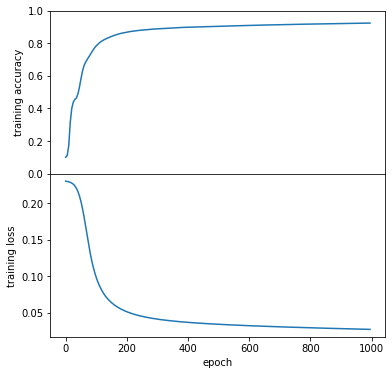

In [124]:
MNIST_MLP.plot_acc_and_loss()

**Figure 7. Accuracy and Loss Against Epoch of My MLP Implementation**

----
## **4. Model Validation**

In [32]:
from datetime import datetime
start=datetime.now()
#With two hidden layers of 100 neurons
MNIST_MLP = MLP([100,100,10], activation = 'relu')
MNIST_MLP.fit(X_train, Y_train, eta = 0.1)
print("Train Accuracy:", MNIST_MLP.predict(X_train, Y_train))
print("Test Accuracy:", MNIST_MLP.predict(X_test, Y_test))

print('Time taken: ', datetime.now()-start)

Iteration: 99 Model Loss:  0.06288214327519671 Train Accuracy: 0.8427
Iteration: 199 Model Loss:  0.03941279500994669 Train Accuracy: 0.8903833333333333
Iteration: 299 Model Loss:  0.03349709105847598 Train Accuracy: 0.9051666666666667
Iteration: 399 Model Loss:  0.03020446095853272 Train Accuracy: 0.9142833333333333
Iteration: 499 Model Loss:  0.0278015512179387 Train Accuracy: 0.92045
Iteration: 599 Model Loss:  0.025858933241847033 Train Accuracy: 0.9257666666666666
Iteration: 699 Model Loss:  0.02419119587900016 Train Accuracy: 0.9309833333333334
Iteration: 799 Model Loss:  0.02269318816720813 Train Accuracy: 0.9354333333333333
Iteration: 899 Model Loss:  0.021334837639109257 Train Accuracy: 0.93925
Iteration: 999 Model Loss:  0.02010240839944917 Train Accuracy: 0.94295
Train Accuracy: 0.94295
Test Accuracy: 0.9419
Time taken:  0:06:18.072265


Besides a 3-layer MLP with a hidden layer of 100 neuron, different architectures of the MLP were explored to increase the test accuracy but not into much detail. This is because the main point of this project is to build a fully-functioning MLP, especial to derive the backprop with SGD from scratch.  An architecture of shape **784x50x10** gives slightly lowerer accuracies (about **0.89** to **0.90**). An architecture of shape **784x100x100x10** gives slightly higher accuracies (**0.9430** and **0.9419**) at the cost of slower training time. Smaller layer sizes were also experimented. At layer sizes of about 20, independent of the number of layers, the test accuracy seems to converge at about 0.11 to 0.12. This is because the number of neuron is incapable of capaturing the vastity of input features (784 is much larger than 20). Different values of eta (learning rate) were also experimented, eta at about **0.03** to **0.05** gave accuracy of about 0.90. Overall, I think a 3-layer architecture of **784x100x10** is the most appropriate for the following evaluations.

We compare our result with a MLP built with TensorFlow.

We build with the same MLP architecture (of shape **784x100x10**) with TensorFlow. We try to keep the initialization of weights and biases the same as previous.

In [10]:
n_classes = Y_train.shape[1]
n_features = X_train.shape[1]

In [45]:
import tensorflow as tf
tf_MLP = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=X_train[0].shape), 
    #although I can choose the same seed number, it wouldn't be in the same random state as when I called `np.random.seed(3270)`
    #when creating the MLP instance
  tf.keras.layers.Dense(100, activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.01, seed=3270),
                        bias_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.01, seed=3270)),  
  tf.keras.layers.Dense(n_classes, activation='softmax'),         
])
tf_MLP.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               78500     
                                                                 
 dense_25 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [63]:
tf_MLP.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Time taken:  2:07:44.338532


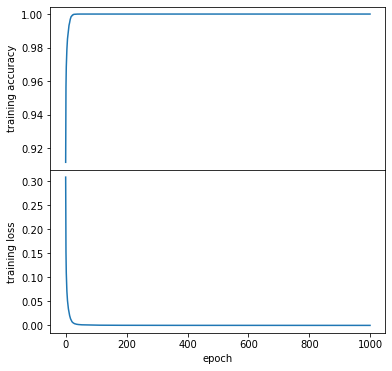

In [64]:
from datetime import datetime
start=datetime.now()

training_history = tf_MLP.fit(X_train, Y_train, epochs=1000, verbose=0)
fig, axes = plt.subplots(2,1, figsize=(6,6), sharex=True)
axes[0].plot(training_history.history['accuracy'])
axes[0].set_ylabel('training accuracy')
axes[1].plot(training_history.history['loss'])
axes[1].set_ylabel('training loss')
axes[1].set_xlabel('epoch')
plt.subplots_adjust(hspace=0.)

print('Time taken: ', datetime.now()-start)

**Figure 8. Accuracy and Loss Against Epoch of tf_MLP (batch_size=32)**

We see that with a small batch size (by default this is **32** for `tf.keras.model.fit`), model accuracy and loss are fast converging to the ideal values (1 and 0 respectively).
However, the training is extremely slow.

Next we change the batch_size to **60,000** (same as `MNIST_MLP`).

In [12]:
tf_MLP2 = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=X_train[0].shape), 
    #although I can choose the same seed number, it wouldn't be in the same random state as when I called `np.random.seed(3270)`
    #when creating the MLP instance
  tf.keras.layers.Dense(100, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform,
                        bias_initializer=tf.keras.initializers.GlorotUniform),  #same initialization as MLP
  tf.keras.layers.Dense(n_classes, activation='softmax'),         
])
tf_MLP2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Time taken:  0:01:17.171843


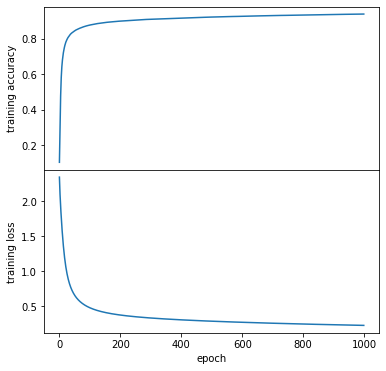

In [13]:
from datetime import datetime
start=datetime.now()

#This time we set the model to train on the whole X_train each batch
training_history2 = tf_MLP2.fit(X_train, Y_train, batch_size = len(X_train), epochs=1000, verbose=0)
fig, axes = plt.subplots(2,1, figsize=(6,6), sharex=True)
axes[0].plot(training_history2.history['accuracy'])
axes[0].set_ylabel('training accuracy')
axes[1].plot(training_history2.history['loss'])
axes[1].set_ylabel('training loss')
axes[1].set_xlabel('epoch')
plt.subplots_adjust(hspace=0.)

print('Time taken: ', datetime.now()-start)

**Figure 9. Accuracy and Loss Against Epoch of tf_MLP2 (batch_size=60,000)**

In [14]:
training_history2.history['accuracy'][-1]

0.9379166960716248

In [15]:
tf_MLP2.evaluate(X_test,  Y_test)

313/313 [==============================] - 0s 406us/step - loss: 0.2195 - accuracy: 0.9366


[0.21954025328159332, 0.9366000294685364]

<br>We see that the train accuracy and test accuracy of the TensorFlow Model are **0.9379** and **0.9366** respectively. These are slightly higher than our implementation of MLP. **This can be due to different initial states or a different implementation of SGD or initializer.**
In addition, the TensorFlow model is much faster than mine with the same batch size (**1 min 17 sec** versus **4 min 17 sec**). This is mostly due to TensorFlow's implementation is superior to mine.<br>

<br>Next, we perform a **K-fold Cross Validation** of `MNIST_MLP`.

In [17]:
from sklearn.model_selection import train_test_split, cross_validate, KFold

In [18]:
X, Y = np.concatenate( (X_train,X_test)), np.concatenate( (Y_train,Y_test))

In [31]:
from datetime import datetime
start=datetime.now()

kf = KFold(n_splits=10)
train_scores, test_scores = [], []
for train_indices, test_indices in kf.split(X):
    KFOLD_MLP = MLP([100,10], activation = 'relu')
    KFOLD_MLP.fit(X[train_indices], Y[train_indices], verbose = False,eta = 0.1)
    train_scores.append(KFOLD_MLP.predict(X[train_indices], Y[train_indices]))
    test_scores.append(KFOLD_MLP.predict(X[test_indices], Y[test_indices]))
    print(f'Test accuracy {test_scores[-1]:0.4f}.')
    
print('Time taken: ', datetime.now()-start)

Test accuracy 0.9361.
Test accuracy 0.9211.
Test accuracy 0.9250.
Test accuracy 0.9286.
Test accuracy 0.9204.
Test accuracy 0.9247.
Test accuracy 0.9217.
Test accuracy 0.9231.
Test accuracy 0.9303.
Test accuracy 0.9396.
Time taken:  0:42:52.906053


In [48]:
print(np.std(train_scores), np.std(test_scores))
print(np.mean(train_scores), np.mean(test_scores))

0.0005176769436525101 0.006199818957198751
0.9306111111111111 0.9270714285714285


We see that the mean of train and test accuracies of 10-fold training are **0.9306** and **0.9271**, with low standard deviations **5e-4** and **6e-3**.

(0.92, 0.94)

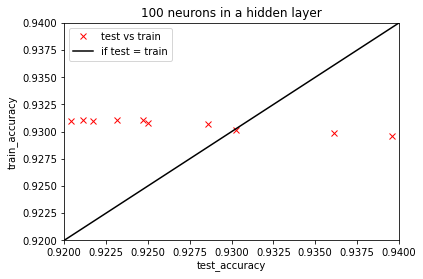

In [49]:
plt.plot(test_scores, train_scores, 'rx', label='test vs train')
plt.xlabel('test_accuracy')
plt.ylabel('train_accuracy')
plt.title('100 neurons in a hidden layer')
x = np.linspace(0,1,100)
plt.plot(x, x, 'k-', label='if test = train')
plt.legend()
plt.ylim([.92,.94])
plt.xlim([.92,.94])

**Figure 10. Train Accuracy Against Test Accuracy (MLP)**

We compare this with our TensorFlow model.

In [22]:
train_scores1, test_scores1 = [], []

for train_indices, test_indices in kf.split(X):
    
    tf_MLP3 = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=X_train[0].shape), 

      tf.keras.layers.Dense(100, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform,
                            bias_initializer=tf.keras.initializers.GlorotUniform),  #same initialization as MLP
      tf.keras.layers.Dense(n_classes, activation='softmax'),         
    ])
    
    tf_MLP3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    
    tf_MLP3.fit(X[train_indices], Y[train_indices], batch_size = len(X[train_indices]), epochs=1000, verbose=0)
    
    train_scores1.append(tf_MLP3.evaluate(X[train_indices], Y[train_indices]))
    test_scores1.append(tf_MLP3.evaluate(X[test_indices], Y[test_indices]))

219/219 [==============================] - 0s 389us/step - loss: 0.1885 - accuracy: 0.9474


In [55]:
print(np.std(train_scores1[:,1]), np.std(test_scores1[:,1]))
print(np.mean(train_scores1[:,1]), np.mean(test_scores1[:,1]))

0.0008648060864319754 0.006464598607864113
0.9389396965503692 0.9346857070922852


For the TensorFlow model, we see that the mean of train and test accuracies of 10-fold training are slight higher: **0.9389** and **0.9346**, with low standard deviations **8e-4** and **6e-3**.

(0.925, 0.95)

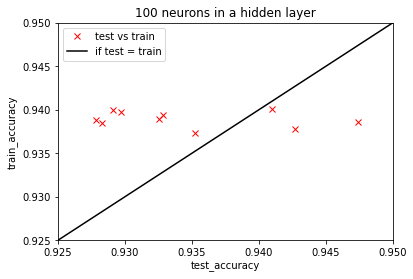

In [57]:
train_scores1, test_scores1 = np.asarray(train_scores1), np.asarray(test_scores1)

plt.plot(test_scores1[:,1], train_scores1[:,1], 'rx', label='test vs train')
plt.xlabel('test_accuracy')
plt.ylabel('train_accuracy')
plt.title('100 neurons in a hidden layer')
x = np.linspace(0,1,100)
plt.plot(x, x, 'k-', label='if test = train')
plt.legend()
plt.ylim([.925,.95])
plt.xlim([.925,.95])

**Figure 11. Train Accuracy Against Test Accuracy (tf_MLP)**

My implementation of MLP worked very well. From the calculations as well as figures 10 & 11, we see that the standard deivation of test accuracies is about **10** times larger than that of train accuracies. This can be a feature of MNIST dataset, and the standard deviation may be reduced if we increase number of layers or layer size. Overall, the observations from the two models agree with other.

## 5. Discussion

### 5.1 The Wrongly Predicted Digits

In [71]:
y_pred = MNIST_MLP.predict_label(X_test)

In [70]:
(dummy1, Y_train_truth), (dummy2, Y_test_truth) = mnist.load_data()

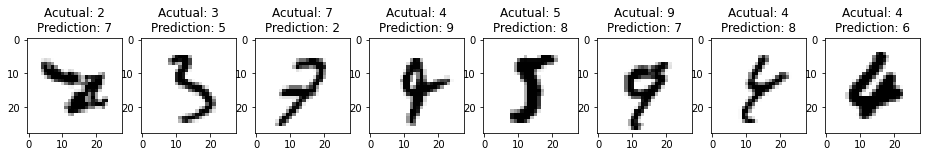

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(16,2))
wrongs = y_pred != Y_test_truth
samp = X_test[wrongs]
y_samp_true = Y_test_truth[wrongs]
y_samp_pred = y_pred[wrongs]
n = len(samp)
for i in range(8):
    idx = np.random.randint(0, n)
    img = np.reshape(samp[idx]*16, (28,28))
    ax[i].imshow(img, cmap='gray_r')
    ax[i].set_title(f"Acutual: {y_samp_true[idx]}\nPrediction: {y_samp_pred[idx]}")

**Figure 12. A Sample of Wrongly Predicted Digits by MNIST_MLP**

By looking at the wrongly predicted digits, we can get an idea what kind of mistakes the model is making in recognizing digits. 

It can be seen that some of the handwritten digits are not easy to tell even with human eyes, these may be recognizable by the model if we add more layers and increase sizes of the layers, for the model to learn for unique features of each digit. For the other wrongly predicted digits, we see that they are either slightly slented or decentered. There are due to MLP's limitations that are going to be elaborated in the next subsection.

### 5.2 Limitation of MLP

<img src="cnn_rotation_invariance.webp" width="600" align="center"><br>
**Figure 13. The Perceptron Function** (<i>Source</i>: <a href="https://pyimagesearch.com/2021/05/14/are-cnns-invariant-to-translation-rotation-and-scaling/"> <i>Adrian Rosebrock</i></a>)


Continuing on the section 3's point about the limitations of MLP in image classification, we know that MLPs only take in vectors as their input. This means that MLPs intrinsically lack spatial awareness. Unlike the intrinsically translation- invariant CNNs, which takes in matrices and can also recognize rotated and scaled images by the benefit of the Max-pooling layer, MLPs are limited to have fully-connected layers and simply cannot recognize translated images. For this section we just look at the rotated digits from the same MNIST dataset.

In [108]:
X_train_T.shape, X_test_T.shape

((60000, 28, 28), (10000, 28, 28))

In [73]:
#preprocess data, see figure 2b
X_train_T, X_test_T = np.asarray([X.flatten() for X in X_train_T]), np.asarray([X.flatten() for X in X_test_T])
X_train_T, X_test_T = X_train_T / 255, X_test_T / 255
print('X_train: ', str(X_train_T.shape))
print('X_test: ', str(X_test_T.shape))

X_train:  (60000, 784)
X_test:  (10000, 784)


In [77]:
MNIST_MLP.predict(X_test_T, Y_test), MNIST_MLP.predict(X_train_T, Y_train)

(0.1785, 0.15096666666666667)

We see the our implementaion totally fails to recognize the digits. The accuracies (**0.1785**, **0.1510**) are not absolutelu atrocious (that is, close to 0.1, the probability of randomly guessing), this may be because of some digits still look more like themselves than the others after the 90 degrees counterclockwise rotation (for example the digit **0**). Nonetheless this is not comparable to our over **93%** accuracy when donw with the dedicated test data. 

### 5.3 Blinkers

In addition, we can also test out the implemented MLP with the gaussian blinkers generator from `blinker.py` in the PC3270 library.

Text(0, 0.5, 'arbitrary feature 2')

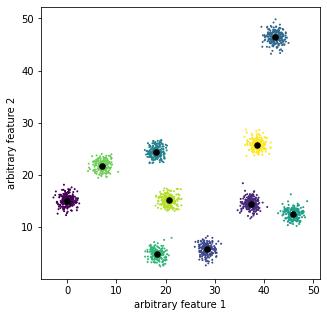

In [84]:
import blinkers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

num_clusters = 10
avg_cluster_size = 200
blink = blinkers.gaussian_blinkers(num_clusters=num_clusters, avg_cluster_size=avg_cluster_size)
blink.gen_data(rand_seed=1)

#spliting train and test data
design_matrix = blink.meas_positions.copy()
labels = blink.truelabels.copy()
X_train_blinker, X_test_blinker, Y_train_blinker, Y_test_blinker = train_test_split(design_matrix, labels, test_size=0.2)

#plotting data
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(blink.meas_positions[:,0], blink.meas_positions[:,1], c=blink.truelabels, s=1)
ax.scatter(blink.truemeans[:,0], blink.truemeans[:,1], c='black', s=30)
ax.set_xlabel('arbitrary feature 1')
ax.set_ylabel('arbitrary feature 2')

**Figure 14. Dataset Generated by `blinker.py`**

Preprocessing the truth-labels:

In [86]:
Y_train_blinker, Y_test_blinker = OneHot.fit_transform(Y_train_blinker.reshape(len(Y_train_blinker), -1)), OneHot.transform(Y_test_blinker.reshape(len(Y_test_blinker), -1))

In this case the design matrix just cosists of 2-dimensional vectors, therefore do not require any preprocessing. We proceed to create an instance and fit these data.

In [89]:
BLINKER_MLP = MLP([100,10])
BLINKER_MLP.fit(X_train_blinker, Y_train_blinker, eta = 0.05)

Iteration: 99 Model Loss:  0.0812330537146224 Train Accuracy: 0.5902140672782875
Iteration: 199 Model Loss:  0.06820692228225242 Train Accuracy: 0.6477064220183486
Iteration: 299 Model Loss:  0.04720587622586201 Train Accuracy: 0.7859327217125383
Iteration: 399 Model Loss:  0.04069887797600464 Train Accuracy: 0.8085626911314985
Iteration: 499 Model Loss:  0.038744658517067966 Train Accuracy: 0.7614678899082569
Iteration: 599 Model Loss:  0.03356512628406271 Train Accuracy: 0.7834862385321101
Iteration: 699 Model Loss:  0.03283997022750902 Train Accuracy: 0.9021406727828746
Iteration: 799 Model Loss:  0.03345009937117194 Train Accuracy: 0.8782874617737003
Iteration: 899 Model Loss:  0.029973470457982508 Train Accuracy: 0.909480122324159
Iteration: 999 Model Loss:  0.0243163361667901 Train Accuracy: 0.9431192660550459


In [90]:
BLINKER_MLP.predict(X_train_blinker, Y_train_blinker), BLINKER_MLP.predict(X_test_blinker, Y_test_blinker)

(0.9431192660550459, 0.9437652811735942)

Expectedly, my implementation gives high accuracy (**0.9431**, **0.9438**) when used on simple data generator such as `blinkers`.

### 5.4 Conclusion

This project has been a long journey. Started from the basics of theory, I have derived the SGD of MLP, implemented the backprop and developed a MLP class fully from scratch. It was a success and produced comparable prediction results in reasonable amount of time to its counterpart built with TensorFlow. I also cross-valided my model with K-Fold Validation and with the MLP built with TensorFlow. I have picked up many syntaxes when dealing with packages such as `tensorflow.keras` and `sklearn`, as well as quite improved my coding skills in general. With a trained and strong basis in MLP, I think my next step is looking at the CNNs, which are a more efficient and powerful class of feedforward neural networks. I have always been fascinated by 3D-GANs since I first saw the <a href="https://marcoamonteiro.github.io/pi-GAN-website/"> $\pi$</a>-GAN paper, now I can properly get my hands on them. 

----
## References

Murphy, K. *Probabilistic Machine Learning: An Introduction*. MIT Press, 2022

Skalski, P. *Let’s code a Neural Network in plain NumPy*. Retrieved from: <a href="https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795"> <i>Towards Data Science</i></a>

Goodfellow et al. *Deep Learning*.  MIT Press, 2016

Agnihotri, A. *Building a Neural Net from Scratch using Numpy*. Retrive from: <a href="https://github.com/akash-agni/DeepLearning/blob/main/Neural_Network_From_Scratch_using_Numpy.ipynb"> <i>GitHub</i></a>

Brownlee, J. *Why One-Hot Encode Data in Machine Learning?* Retrive from: <a href="https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/"> <i>Machine Learning Mystery</i></a>

Brownlee, J. *A Gentle Introduction to k-fold Cross-Validation* Retrive from: <a href="https://machinelearningmastery.com/k-fold-cross-validation/"> <i>Machine Learning Mystery</i></a>

Jana, A. *Understanding and implementing Neural Network with SoftMax in Python from scratch* Retrive from: <a href="http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/"> <i>A Developer Diary</i></a>

Jaderberg, M. *Spatial Transformer Networks* In: *NIPS 2015*

Khan, R. *Nothing but NumPy: Understanding & Creating Neural Networks with Computational Graphs from Scratch* <a href="https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html"> <i>A Developer Diary</i></a>

Brown, T et al. *Language Models are Few-Shot Learners*. In: (May 2020). arXiv:<a href="https://arxiv.org/abs/2005.14165"> <i>2005.14165</i></a> .

McCaffrey, J. *Neural Network Glorot Initialization* Retrive from: <a href="https://jamesmccaffrey.wordpress.com/2017/06/21/neural-network-glorot-initialization/"> <i>WordPress</i></a>

Raschka, S. *Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning* In: (Nov 2018). arXiv:<a href="https://arxiv.org/abs/1811.12808"> <i>1811.12808</i></a> .